# Example 1: Waterflood Simulation in 2D Aquifer using X-MeshGraphNet

## 1. Introduction 

### From 2D to 3D: Industry-Scale Challenges

In **Example 1**, we explored a simplified 2D waterflood problem. While useful for learning, real-world reservoir engineering deals with:

- **3D geology**: Complex stratigraphic layers
- **Structural features**: Faults that compartmentalize the reservoir
- **Multiple wells**: Dozens of producers and injectors
- **Large scale**: Millions of grid cells
- **Complex physics**: Non-neighbor connections, dual-porosity systems

### Why Norne Field?

The **Norne Field** is a well-known benchmark in reservoir engineering:

**Publicly available** through the [OPM project](https://github.com/OPM/opm-data/tree/master/norne)  
**Real field data** from the Norwegian Sea  
**Complex geology** with numerous faults  
**Industry-standard** used for research and benchmarking  
**Challenging for AI/ML** due to non-trivial connectivity  


## 2. Norne Field Overview 

### Simulation Model Characteristics

| Property | Value |
|----------|-------|
| **Grid Dimensions** | ~45,000 active cells (of ~150,000 total) |
| **Phases** | Oil, water, gas (3-phase flow) |
| **Wells** | Multiple producers and injectors |
| **Faults** | 50+ faults with Non-Neighbor Connections (NNCs) |
| **Simulation Period** | 10+ years of operation |
| **Complexity** | High - industry-representative model |

### Dataset for This Example

For this tutorial, we use a **Design of Experiment (DOE)** based dataset:

- **500 simulation cases**
- **Varied parameters**:
  - **Fault transmissibility multipliers**: Controls flow across faults
  - **KVKH multipliers**: Vertical vs horizontal permeability ratio
- **Sampling method**: Latin Hypercube Sampling (LHS) for good coverage
- **Simulator**: OPM Flow (open-source reservoir simulator)


### Non-Neighbor Connections (NNCs)

**What are NNCs?**

Normally, grid cells connect only to their immediate neighbors. However, **faults** create connections between non-adjacent cells:

```
Normal Grid:                  Faulted Grid:
┌───┬───┬───┐                ┌───┬───║   ┬───┐
│ 1 │ 2 │ 3 │                │ 1 │ 2 ║   │ 6 │
├───┼───┼───┤                ├───┼───║   ┼───┤
│ 4 │ 5 │ 6 │                │ 4 │ 5 ║   │ 9 │  ← Fault
├───┼───┼───┤                ├───┼───║───┼───┤
│ 7 │ 8 │ 9 │                │ 7 │ 8 ║ X │ 12│  ← NNC: 8↔12
└───┴───┴───┘                └───┴───║───┴───┘

Regular connections only    Cells 8 and 12 connect
                           across the fault (NNC)
```

## 3. X-MGN Advantages for Complex Reservoirs

### Why X-MeshGraphNet is Ideal for Norne

#### 1. Natural Fault Representation

```python
# In the graph:
regular_edges = [...] # Normal neighbor connections
nnc_edges = [...]     # Fault connections
all_edges = regular_edges + nnc_edges  # Simply combined!

# Each edge has transmissibility as a feature
edge_features = [TRANX, TRANY, TRANZ, TRANNNC]
```

The model **automatically learns** how faults affect flow!

#### 2. Scalability through Partitioning

```
Full Model (45k cells)              Partitioned Model
┌─────────────────────┐            ┌──────────┬──────────┐
│                     │            │ Partition│ Partition│
│    Too large for    │    ───▶    │    1     │    2     │
│    single GPU!      │            │ (GPU 1)  │ (GPU 2)  │
│                     │            └──────────┴──────────┘
└─────────────────────┘                  ▲         ▲
                                         │         │
                                    Halo regions allow
                                    information exchange
```

- Split graph into **manageable partitions**
- Each partition trains on **separate GPU**
- **Halo regions** (overlap) maintain continuity
- Scales to **millions of cells**

#### 3. Physics-Aware Architecture

**Message Passing Mimics Physical Diffusion**:

```
Layer 1: Information propagates 1 connection away
Layer 2: Information propagates 2 connections away
Layer 3: Information propagates 3 connections away
...
```

This resembles how **pressure signals propagate** through the reservoir!

#### 4. Handles Arbitrary Topology

- Variable cell sizes  
- Pinch-outs and geological features  
- Dual-porosity systems (matrix-fracture)  

## 4. Workflow Overview <a id="workflow-overview"></a>

The workflow is similar to Example 1, but with additional considerations for scale and complexity:

```
┌──────────────────────────────────────────────────────────────────┐
│              X-MGN Workflow for Norne Field                       │
└──────────────────────────────────────────────────────────────────┘

Norne Dataset (500 cases)           Trained Surrogate Model
   ├─ BASE.INIT                              (Fast Predictions)
   ├─ BASE.EGRID                                   ▲
   ├─ BASE.UNRST                                   │
   └─ DOE variants                                 │
         │                                          │
         ▼                                          │
┌──────────────────┐    ┌──────────────┐    ┌─────────────────┐
│  1. Prepare      │───▶│ 2. Configure │───▶│ 3. Preprocess   │
│     Norne Data   │    │    for 3D    │    │    Build Graphs │
└──────────────────┘    │   Complexity │    │    Extract NNCs │
                        └──────────────┘    └─────────────────┘
                                                     │
                                                     ▼
                                           ┌──────────────────┐
                                           │ Graph Dataset    │
                                           │ - 45k nodes      │
                                           │ - NNC edges      │
                                           │ - Multi-phase    │
                                           └──────────────────┘
                                                     │
                                                     ▼
                                           ┌──────────────────┐
                                           │  4. Train Model  │
                                           │  - Multi-GPU     │
                                           │  - Graph parts.  │
                                           │  - Longer time   │
                                           └──────────────────┘
                                                     │
                                                     ▼
                                           ┌──────────────────┐
                                           │ 5. Inference &   │
                                           │    Visualization │
                                           │ - 3D fields      │
                                           │ - ResInsight     │
                                           └──────────────────┘

## 5. Prerequisites & Setup 
First, ensure you're in the correct directory and have all dependencies installed. You can use the physicsnemo container, or do "pip install -r requirements.txt"

In [1]:
##Install required dependencies (if not already installed)
# !pip install -r requirements.txt

In [2]:
# Import necessary libraries and check gpus available
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0a0+145a3a7bda.nv25.10
CUDA available: True
CUDA version: 13.0
GPU device: NVIDIA H100 80GB HBM3


## 6. Step 1: Dataset Preparation 

The X-MGN framework expects simulation data in **ECLIPSE/IX format**. This is an industry-standard format used by many reservoir simulators. The required Files per Case

| File Type | Extension | Contents |
|-----------|-----------|----------|
| **Data File** | `.DATA` | Simulation input specification |
| **Initial State** | `.INIT` | Static properties (permeability, porosity) |
| **Grid** | `.EGRID` | Grid geometry and topology |
| **Restart** | `.UNRST` | Dynamic properties over time (pressure, saturation) |
| **Summary** | `.UNSMRY` | Well data and field totals (optional) |

The Norne dataset should be organized as follows:

```
../dataset/Norne/
├── BASE_CASE/
│   ├── NORNE_ATW2013.DATA
│   ├── NORNE_ATW2013.INIT
│   ├── NORNE_ATW2013.EGRID
│   └── NORNE_ATW2013.UNRST
├── CASE_001/
│   ├── NORNE_001.DATA
│   ├── NORNE_001.INIT
│   ├── NORNE_001.EGRID
│   └── NORNE_001.UNRST
├── CASE_002/
│   └── ...
└── ... (500 cases total)
```

In [3]:
# We will check if the simulations file are in place
dataset_path = Path("../dataset/2D_OW/CASE_2D.sim")

# Check if dataset exists
if dataset_path.exists():
    print(f"Dataset found at: {dataset_path.absolute()}")
    
    # Count simulation cases
    init_files = list(dataset_path.glob("*.INIT"))
    egrid_files = list(dataset_path.glob("*.EGRID"))
    unrst_files = list(dataset_path.glob("*.UNRST"))
    
    print(f"\nDataset Statistics:")
    print(f"  - .INIT files: {len(init_files)}")
    print(f"  - .EGRID files: {len(egrid_files)}")
    print(f"  - .UNRST files: {len(unrst_files)}")
    
else:
    print(f" Dataset not found at: {dataset_path.absolute()}")
    print(f"\n Please ensure your dataset is downloaded and the path in config.yaml is correct.")
    print(f"   Expected location: {dataset_path.absolute()}")

Dataset found at: /workspace/lab_3/xmgn/../dataset/2D_OW/CASE_2D.sim

Dataset Statistics:
  - .INIT files: 10
  - .EGRID files: 10
  - .UNRST files: 10


## 7. Step 2: Configuration 

The configuration file (`conf/config.yaml`) controls all aspects of the workflow. Let's look at the key sections.

### Configuration Structure

The config file is organized into logical sections:

```yaml
├── hydra             # Experiment naming and output directories
├── runspec           # Job description
├── dataset           # Data location and graph features
├── preprocessing     # Graph building parameters
├── model             # Neural network architecture
├── training          # Training hyperparameters
├── performance       # Optimization settings
└── inference         # Prediction settings
```

In [4]:
# View the configuration file
# !cat config_norne.yaml

### Modifying the Configuration

For this tutorial, the default configuration should work well. However, you might want to adjust:

- **`dataset.sim_dir`**: If your data is in a different location
- **`training.num_epochs`**: Reduce for faster testing (e.g., 100)
- **`preprocessing.num_preprocess_workers`**: Match your CPU cores

You can edit the config file directly or create a new config in the `conf/` directory.

## 8. Step 3: Data Preprocessing 

The preprocessing step transforms raw simulation data into graph structures suitable for GNN training.

### Preprocessing Pipeline

```
┌─────────────────────────────────────────────────────────┐
│              Preprocessing Pipeline                     │
└─────────────────────────────────────────────────────────┘

1. Read Binary Files (.INIT, .EGRID, .UNRST)
   ↓
2. Extract Grid Geometry
   - Cell centers (X, Y, Z coordinates)
   - Cell connections (neighbors)
   ↓
3. Extract Node Features
   - Static: PERMX, PORV (from .INIT)
   - Dynamic: PRESSURE, SWAT at each timestep (from .UNRST)
   ↓
4. Extract Edge Features
   - Transmissibility values (TRANX, TRANY, TRANZ)
   ↓
5. Build Graph Structure
   - Nodes: Grid cells with features
   - Edges: Connections with transmissibility
   ↓
6. Create Training Sequences
   - Input: timesteps t-2, t-1, t
   - Target: timestep t+1
   ↓
7. Normalize Features
   - Scale to [0, 1] or apply log transform
   ↓
8. Partition Graphs (if num_partitions > 1)
   - Split into subgraphs
   - Add halo regions
   ↓
9. Save Processed Graphs (.pt files)
```

In [5]:
# %%time
# # Run preprocessing (this may take several minutes depending on dataset size)
# !python src/preprocessor.py --config-name=config_norne

### Understanding the Graph Structure

Each processed graph (`.pt` file) contains:

```python
graph = {
    'x': Node features [num_nodes, feature_dim],
         # Concatenation of:
         # - Static features (PERMX, PORV, X, Y, Z)
         # - Dynamic features at t-2, t-1, t for PRESSURE, SWAT, WCID
         #   (total: 3 timesteps × 3 vars = 9 features)
         # - delta_t (time step size) - broadcasted to all nodes [1 feature]
         # - time (normalized 0-1) - broadcasted to all nodes [1 feature]
         # Total: 5 + 9 + 1 + 1 = 16 features per node
    
    'edge_index': Edge connectivity [2, num_edges],
                  # [source_nodes, target_nodes]
    
    'edge_attr': Edge features [num_edges, 1],
                 # Transmissibility values (log10 scaled)
    
    'y': Target values [num_nodes, 2],
         # PRESSURE and SWAT at timestep t+1
    
    'grid_info': dict,
         # Metadata: nx, ny, nz, total_cells, active_cells,
         # sample_idx, timestep_idx, target_timestep,
         # input_vars (list of feature names), target_vars
    
    'case_name': str,
                 # e.g., "CASE_2D_1"
    
    'timestep_id': int,
                   # Current timestep index
    
    'coordinates': [num_nodes, 3],  # ONLY if X,Y,Z NOT in node features
                   # Cell centers (X, Y, Z)
}
```

To see the graph partitioning and halo regions see visualize_regions_graph_3D_norne_plotly.ipynb

## 9. Step 4: Model Training 

The training process optimizes the X-MGN model to predict the next timestep given the current and previous states.

```
For each epoch:                                          
    For each batch of partitioned graphs:                
        
        1. Load PARTITIONS (not full graphs):           
           - Each sample has multiple partitions
           - Each partition has inner + halo nodes
        
        2. For each partition:
           - Forward pass: model(x, edge_attr, graph)   
           - Prediction: next timestep (t+1)
           - Extract INNER nodes only                  
        
        3. Compute loss:                              
           - PRESSURE: L2 loss (MSE)                    
           - SWAT: L1 loss (MAE)                        
           - Weighted sum: weights * losses             
           - Gradient accumulation across partitions    
        
        4. Backward pass (per partition):               
           - loss.backward() for each partition
           - Accumulate gradients
        
        5. Update model weights (after all partitions): 
           - optimizer.step()
           - scaler.update() (if GPU/mixed precision)
    
    Every validation_freq epochs (default: 5):          
        - Validate on validation set                    
        - Compute metrics (MAE, RMSE per variable)      
        - Save BEST checkpoint if improved              
        - Save regular checkpoint                       
        - Log metrics to MLflow (automatic)             
        - Check early stopping                          
    
    Update learning rate (cosine annealing):            
        - scheduler.step()
```

In [6]:
# Single GPU training
# Note: This will take significant time (hours) depending on your hardware
# You may want to run this in a terminal session instead

# !python src/train.py --config-name=config_norne

In [7]:
# Multi-GPU training with 8 GPUs (Multi GPU recommended)
# Adjust --nproc_per_node to match your available GPUs
# !torchrun --nproc_per_node=8 --nnodes=1 src/train.py --config-name=config_norne

After training you will see the following output files: 
```
outputs/XMGN_Norne/
├── checkpoints/                    # Regular checkpoints (every 5 epochs)
│   ├── checkpoint.0.5.pt
│   ├── checkpoint.0.10.pt
│   └── MeshGraphNet.0.10.mdlus
├── best_checkpoints/               # Best model (lowest val loss)
│   ├── checkpoint.0.25.pt
│   └── MeshGraphNet.0.25.mdlus
├── mlruns/                         # MLflow tracking
│   └── experiment_id/
│       └── run_id/
│           ├── metrics/
│           ├── params/
│           └── artifacts/
└── .hydra/                         # Hydra config snapshots

## 10. Step 5: Inference & Visualization 
During inference, the model predicts future states **autoregressively**:

1. Load trained model from best_checkpoints/
2. Load global statistics (for normalization)
3. Load test dataset (partitioned graphs)
4. Set model to eval mode

```
Initial Conditions (from simulator):
    t=0, t=1, t=2
         ↓
    [X-MGN Model]
         ↓
    Predict t=3
         ↓
Use t=1, t=2, t=3 (predicted) → Predict t=4
         ↓
Use t=2, t=3, t=4 (predicted) → Predict t=5
         ↓
    ... continue for all timesteps
```
After the initial timesteps, the model feeds its own predictions back as input. This is called **autoregressive rollout**.



In [8]:
# Run inference on test set. Checkpoints are provided
# !python src/inference.py --config-name=config_norne

### Results Visualization 

In [9]:
import torch
import numpy as np
import h5py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import json


In [10]:
# Path to inference output directory
inference_dir = Path("outputs/XMGN_Norne/inference")

# Path to dataset for coordinates
dataset_dir = Path("../dataset/Norne/NORNE_ATW2013_LHS.sim.dataset/XMGN_Norne")

# Load Inference results
def load_inference_results(h5_file):
    """Load predictions and targets from HDF5 file."""
    predictions = {}
    targets = {}
    
    with h5py.File(h5_file, 'r') as f:
        # Load predictions
        for var in f['predictions'].keys():
            predictions[var] = {}
            for timestep_key in f['predictions'][var].keys():
                timestep = int(timestep_key.split('_')[1])
                predictions[var][timestep] = f['predictions'][var][timestep_key][:]
        
        # Load targets
        for var in f['targets'].keys():
            targets[var] = {}
            for timestep_key in f['targets'][var].keys():
                timestep = int(timestep_key.split('_')[1])
                targets[var][timestep] = f['targets'][var][timestep_key][:]
        
        # Load metadata
        metadata = {
            'case_name': f.attrs['case_name'],
            'num_timesteps': f.attrs['num_timesteps'],
            'target_variables': list(f.attrs['target_variables']),
            'avg_loss': f.attrs['avg_loss']
        }
    
    return predictions, targets, metadata

def load_coordinates(case_name, timestep=2):
    """Load X, Y, Z coordinates from graph file."""
    graph_file = dataset_dir / "graphs" / f"{case_name}_{timestep:03d}.pt"
    graph = torch.load(graph_file, weights_only=False)
    
    if hasattr(graph, 'coordinates'):
        coords = graph.coordinates.numpy()
    else:
        coords = graph.x[:, 2:5].numpy()  # X, Y, Z after PERMX, PORV
    
    return coords[:, 0], coords[:, 1], coords[:, 2]

In [11]:
# Find cases
print("Searching for inference results...")
h5_files = sorted(inference_dir.glob("*.hdf5"))
print(f"Found {len(h5_files)} inference result files")

if len(h5_files) > 0:
    for i, f in enumerate(h5_files[:5]):  # Show first 5
        print(f"  [{i}] {f.stem}")
    if len(h5_files) > 5:
        print(f"  ... and {len(h5_files) - 5} more")

#Select case
# Option 1: Select by index
case_index = 0  # Change this number

# Option 2: Select by name (uncomment to use)
# case_name = "NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0000"
# case_index = next(i for i, f in enumerate(h5_files) if f.stem == case_name)

selected_file = h5_files[case_index]
print(f"\n{'='*70}")
print(f"Selected case [{case_index}]: {selected_file.stem}")
print(f"{'='*70}")


Searching for inference results...
Found 10 inference result files
  [0] NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0003
  [1] NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0012
  [2] NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0013
  [3] NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0015
  [4] NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0016
  ... and 5 more

Selected case [0]: NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0003


In [12]:
# Load the data
predictions, targets, metadata = load_inference_results(selected_file)
case_name = metadata['case_name']

print(f"\nCase: {case_name}")
print(f"Number of timesteps: {metadata['num_timesteps']}")
print(f"Target variables: {metadata['target_variables']}")
print(f"Average loss: {metadata['avg_loss']:.6f}")

# Load coordinates
X, Y, Z = load_coordinates(case_name)
num_nodes = len(X)

print(f"\nNumber of active nodes: {num_nodes}")
print(f"X range: [{X.min():.1f}, {X.max():.1f}] m")
print(f"Y range: [{Y.min():.1f}, {Y.max():.1f}] m")
print(f"Z range: [{Z.min():.1f}, {Z.max():.1f}] m")

# Get available timesteps
available_timesteps = sorted(predictions['PRESSURE'].keys())
print(f"\nAvailable timesteps: {available_timesteps}")


Case: NORNE_ATW2013_DOE_TOP15_EXTENDED_LHS_0003
Number of timesteps: 62
Target variables: ['PRESSURE', 'SWAT']
Average loss: 0.032654


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Number of active nodes: 44431
X range: [455541.9, 462649.8] m
Y range: [7319246.5, 7326988.0] m
Z range: [2467.1, 3061.6] m

Available timesteps: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


In [13]:
# Visualization
# Select timestep to visualize
timestep = available_timesteps[20]  # Change index to see different timesteps
print(f"\n{'='*70}")
print(f"Visualizing timestep {timestep}")
print(f"{'='*70}")

# Get data for this timestep
pressure_true = targets['PRESSURE'][timestep]
pressure_pred = predictions['PRESSURE'][timestep]
swat_true = targets['SWAT'][timestep]
swat_pred = predictions['SWAT'][timestep]

# Calculate errors
pressure_error = pressure_pred - pressure_true
swat_error = swat_pred - swat_true

print(f"\nPressure:")
print(f"  True range: [{pressure_true.min():.2f}, {pressure_true.max():.2f}]")
print(f"  Pred range: [{pressure_pred.min():.2f}, {pressure_pred.max():.2f}]")
print(f"  MAE: {np.abs(pressure_error).mean():.2f}")
print(f"  RMSE: {np.sqrt((pressure_error**2).mean()):.2f}")

print(f"\nWater Saturation:")
print(f"  True range: [{swat_true.min():.4f}, {swat_true.max():.4f}]")
print(f"  Pred range: [{swat_pred.min():.4f}, {swat_pred.max():.4f}]")
print(f"  MAE: {np.abs(swat_error).mean():.4f}")
print(f"  RMSE: {np.sqrt((swat_error**2).mean()):.4f}")



Visualizing timestep 23

Pressure:
  True range: [95.57, 556.69]
  Pred range: [95.71, 624.53]
  MAE: 4.62
  RMSE: 12.16

Water Saturation:
  True range: [0.0000, 1.0000]
  Pred range: [-0.0011, 1.0004]
  MAE: 0.0060
  RMSE: 0.0095


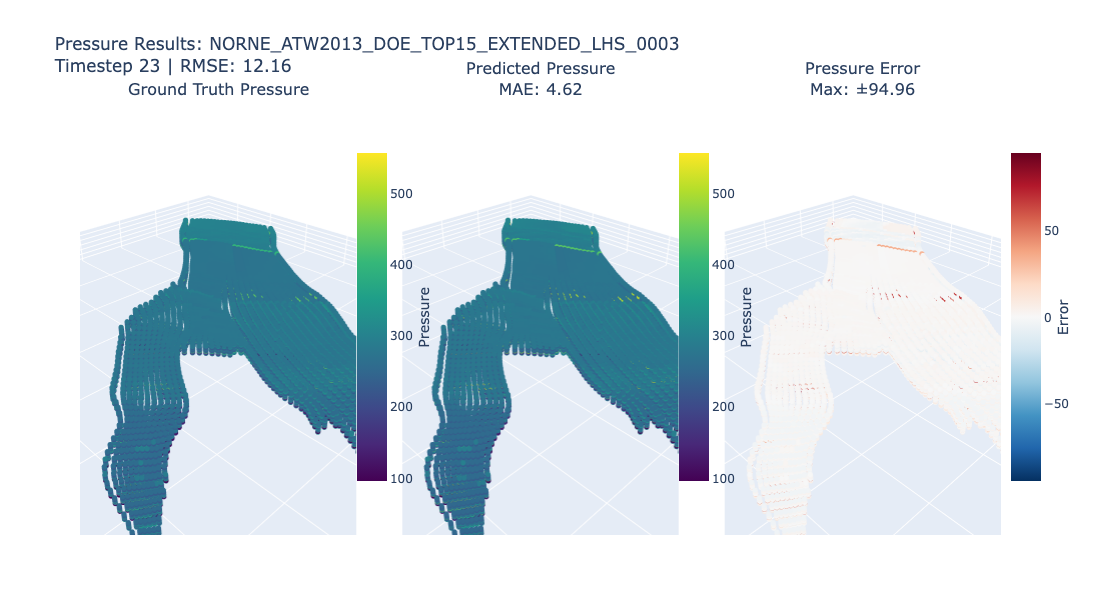

In [14]:
# VisualizationPRESSURE - True, Predicted, Error


# Fixed bounds based on ground truth
vmin_p = pressure_true.min()
vmax_p = pressure_true.max()
error_max_p = max(abs(pressure_error.min()), abs(pressure_error.max()))

fig_pressure = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=(
        f'Ground Truth Pressure', 
        f'Predicted Pressure<br>MAE: {np.abs(pressure_error).mean():.2f}', 
        f'Pressure Error<br>Max: ±{error_max_p:.2f}'
    ),
    horizontal_spacing=0.05
)

# Pressure - Ground Truth
fig_pressure.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=pressure_true,
            colorscale='Viridis',
            cmin=vmin_p,
            cmax=vmax_p,
            showscale=True,
            colorbar=dict(
                x=0.29, 
                len=0.8, 
                title=dict(text='Pressure', side='right')
            )
        ),
        name='True',
        showlegend=False
    ),
    row=1, col=1
)

# Pressure - Predicted (same bounds as ground truth)
fig_pressure.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=pressure_pred,
            colorscale='Viridis',
            cmin=vmin_p,
            cmax=vmax_p,
            showscale=True,
            colorbar=dict(
                x=0.64, 
                len=0.8, 
                title=dict(text='Pressure', side='right')
            )
        ),
        name='Predicted',
        showlegend=False
    ),
    row=1, col=2
)

# Pressure - Error (symmetric around zero)
fig_pressure.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=pressure_error,
            colorscale='RdBu_r',
            cmin=-error_max_p,
            cmax=error_max_p,
            showscale=True,
            colorbar=dict(
                x=1.0, 
                len=0.8, 
                title=dict(text='Error', side='right')
            )
        ),
        name='Error',
        showlegend=False
    ),
    row=1, col=3
)

# Update layout for pressure figure
fig_pressure.update_layout(
    title_text=f'Pressure Results: {case_name}<br>Timestep {timestep} | RMSE: {np.sqrt((pressure_error**2).mean()):.2f}',
    height=600,
    width=1800,
    showlegend=False
)

# Update all 3D scene properties
for i in range(1, 4):
    scene_name = f'scene{i}' if i > 1 else 'scene'
    fig_pressure.update_layout({
        scene_name: dict(
            aspectmode='data',
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
        )
    })

fig_pressure.show()


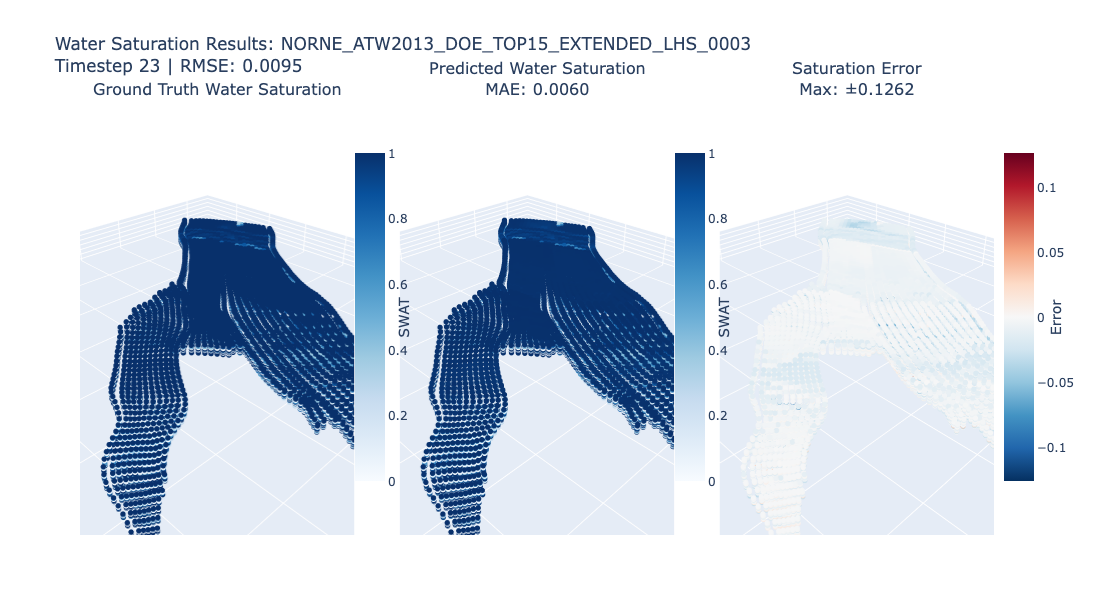

In [15]:
# Visualization WATER SATURATION - True, Predicted, Error


# Fixed bounds based on ground truth
vmin_s = swat_true.min()
vmax_s = swat_true.max()
error_max_s = max(abs(swat_error.min()), abs(swat_error.max()))

fig_swat = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=(
        f'Ground Truth Water Saturation', 
        f'Predicted Water Saturation<br>MAE: {np.abs(swat_error).mean():.4f}', 
        f'Saturation Error<br>Max: ±{error_max_s:.4f}'
    ),
    horizontal_spacing=0.05
)

# SWAT - Ground Truth
fig_swat.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=swat_true,
            colorscale='Blues',
            cmin=vmin_s,
            cmax=vmax_s,
            showscale=True,
            colorbar=dict(
                x=0.29, 
                len=0.8, 
                title=dict(text='SWAT', side='right')
            )
        ),
        name='True',
        showlegend=False
    ),
    row=1, col=1
)

# SWAT - Predicted (same bounds as ground truth)
fig_swat.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=swat_pred,
            colorscale='Blues',
            cmin=vmin_s,
            cmax=vmax_s,
            showscale=True,
            colorbar=dict(
                x=0.64, 
                len=0.8, 
                title=dict(text='SWAT', side='right')
            )
        ),
        name='Predicted',
        showlegend=False
    ),
    row=1, col=2
)

# SWAT - Error (symmetric around zero)
fig_swat.add_trace(
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(
            size=3,
            color=swat_error,
            colorscale='RdBu_r',
            cmin=-error_max_s,
            cmax=error_max_s,
            showscale=True,
            colorbar=dict(
                x=1.0, 
                len=0.8, 
                title=dict(text='Error', side='right')
            )
        ),
        name='Error',
        showlegend=False
    ),
    row=1, col=3
)

# Update layout for SWAT figure
fig_swat.update_layout(
    title_text=f'Water Saturation Results: {case_name}<br>Timestep {timestep} | RMSE: {np.sqrt((swat_error**2).mean()):.4f}',
    height=600,
    width=1800,
    showlegend=False
)

# Update all 3D scene properties
for i in range(1, 4):
    scene_name = f'scene{i}' if i > 1 else 'scene'
    fig_swat.update_layout({
        scene_name: dict(
            aspectmode='data',
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
        )
    })

fig_swat.show()